In [16]:
import pandas as pd
import seaborn as sns
import missingno as msno

In [2]:
df = sns.load_dataset('mpg')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


<AxesSubplot:>

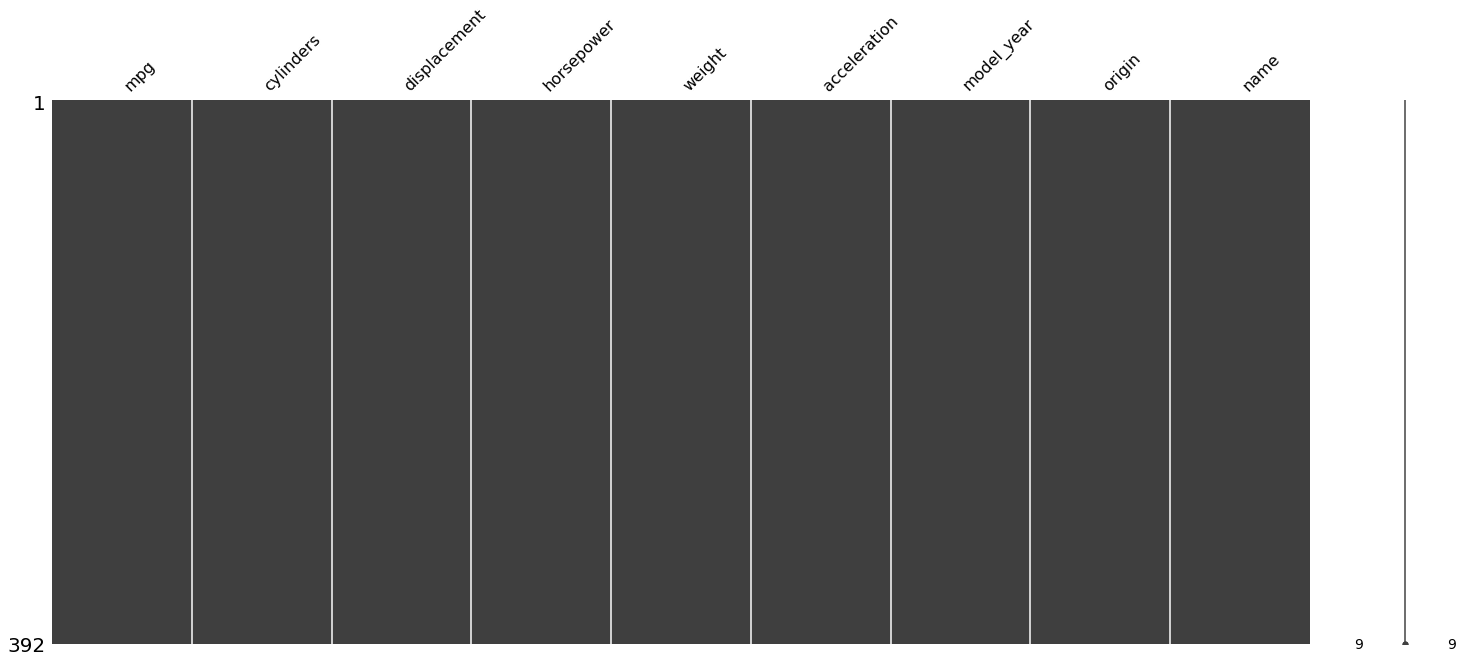

In [18]:
df = df.dropna()   # drop rows with na values (in any column)
msno.matrix(df)

In [145]:
target = 'origin'
features = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
#features = ['mpg', 'horsepower']

In [146]:
X = df[features]
y = df[target]

In [148]:
import plotly.express as px
px.scatter_3d(x=df.mpg, y=df.displacement, z=df.horsepower, color=df.origin)

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)

knn.score(X_test, y_test)

0.6962025316455697

In [108]:
knn = KNeighborsClassifier(n_neighbors=40)
scores = cross_val_score(knn, X, y, cv=10)
scores.mean()

0.6937627202100887

In [149]:
scores = []
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # use train-test-split
    #knn.fit(X_train, y_train)
    #accuracy = knn.score(X_test, y_test)
    
    # use cross validation
    accuracy = cross_val_score(knn, X, y, cv=20).mean()  # mean of accuracies
    
    scores.append([k, accuracy])


In [150]:
knn = KNeighborsClassifier()

# parameter grid ist Modellspezifisch!
# kNN --> variiere k
param_grid = {
    'n_neighbors' : range(1, 100, 5),
    'p' : [1, 2]
}

search = GridSearchCV(knn, param_grid, cv=10)

# start training
search.fit(X, y)
print(f"Best parameter {search.best_params_} - best score {search.best_score_}")

Best parameter {'n_neighbors': 4, 'p': 1} - best score 0.7244897959183674


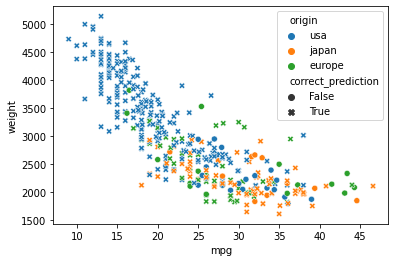

In [156]:
df_viz = pd.DataFrame(X).copy()
df_viz['origin'] = y
df_viz['prediction'] = search.predict(X)
df_viz['correct_prediction'] = (df_viz.origin == df_viz.prediction)
sns.scatterplot(data=df_viz, x='mpg', y='weight', hue='origin', style='correct_prediction'); plt.show()

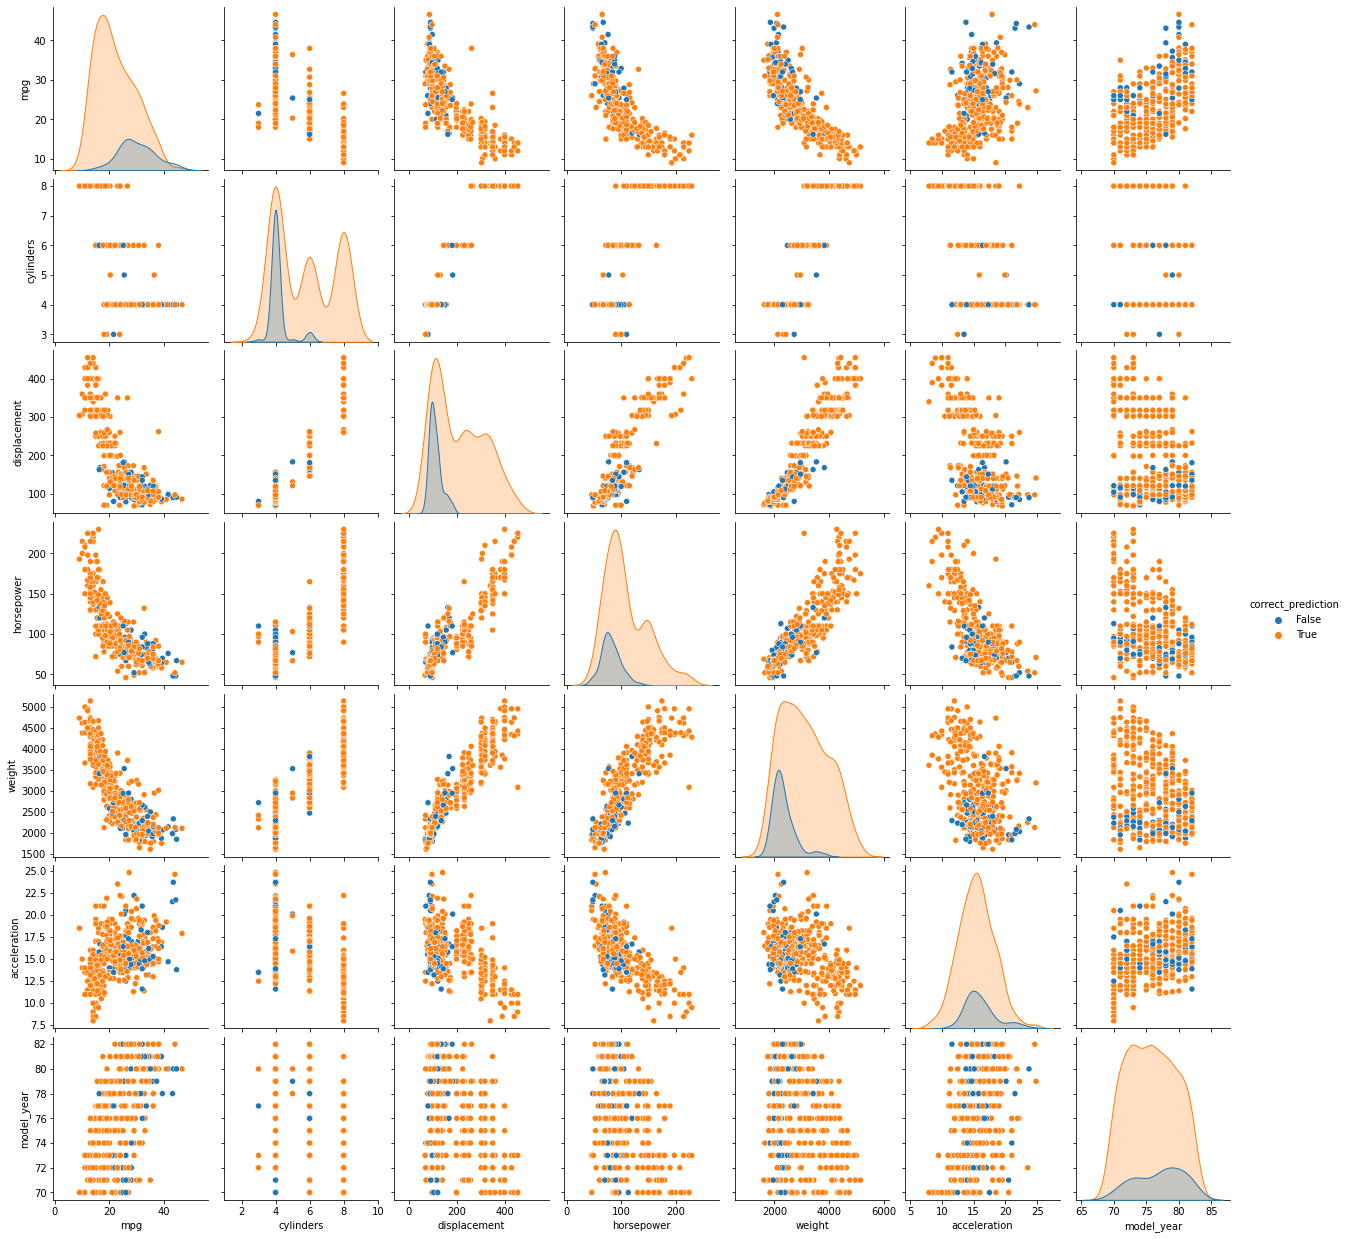

In [161]:
df_viz = pd.DataFrame(X).copy()
df_viz['origin'] = y
df_viz['prediction'] = search.predict(X)
df_viz['correct_prediction'] = (df_viz.origin == df_viz.prediction)
sns.pairplot(data=df_viz, hue='correct_prediction'); plt.show()

In [155]:
search.predict([[15, 6, 300, 90, 4000, 14, 72], [30, 4, 180, 70, 2000, 14, 72]])

array(['usa', 'europe'], dtype=object)

In [151]:
scores_df = pd.DataFrame(scores, columns=['k', 'accuracy'])
px.line(x=scores_df.k, y=scores_df.accuracy)

In [43]:
from sklearn.preprocessing import MinMaxScaler  # in order to understand the decision boundary, we'll normalize our data

X = MinMaxScaler().fit_transform(df[['mpg', 'horsepower']])
y = df['origin'].map({'usa':1, 'europe':2, 'japan':3})  # the visualization below cannot work with nominal values

knn_arr = []  # this array holds the knn-predictors
knn_name_arr = []  # this array holds the names of the knn-predictors for visualization
for i in range(9):
    neighbors = 1
    if(i>0):
        neighbors = i*6
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X, y)
    knn_arr.append(knn)
    knn_name_arr.append("KNN (k={})".format(neighbors))


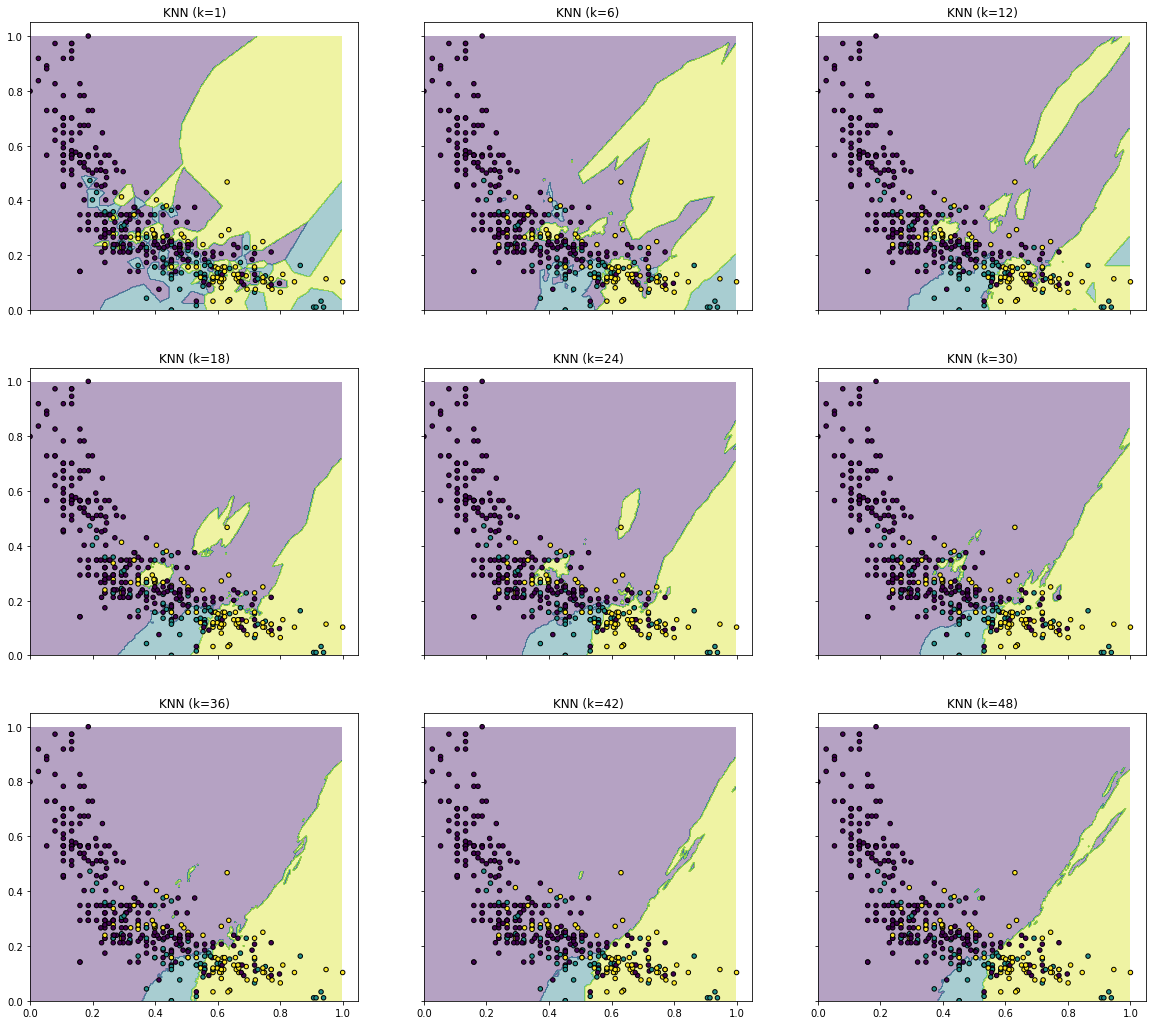

In [46]:
# for the approach, see https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min(), X[:, 0].max()  # this is always 0,1 if MinMaxSclaer is used
y_min, y_max = X[:, 1].min(), X[:, 1].max() # this is always 0,1 if MinMaxSclaer is used
steps = 300  # --> looks better if larger
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/steps),
                     np.arange(y_min, y_max, (y_max-y_min)/steps))  


f, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 18))

# for each model, create the decision boundary and plot it into the right sub-plot (via idx)
for idx, clf, tt in zip(product([0,1,2], [0,1,2]), knn_arr, knn_name_arr):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)  # predict the mesh
       
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)  # draw decision boundary
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')  # plot the original data (normalized)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()